In [1]:
%%capture
!pip install stockstats
# !pip install stable-baselines3

In [2]:
# import gymnasium as gym
# import gym_trading_env

import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import copy

from stockstats import wrap, unwrap 

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from tqdm import tqdm

from plotly import tools, offline
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
import plotly.express as px
import plotly.graph_objs as go


# from stable_baselines3.common.env_checker import check_env
# from stable_baselines3 import PPO
# from stable_baselines3 import A2C
# from stable_baselines3.common.monitor import Monitor
# from stable_baselines3.common.callbacks import CheckpointCallback

import datetime
from dateutil.relativedelta import relativedelta
from datetime import timedelta

## Среда

In [3]:
import numpy as np
import pandas as pd

class History:
    def __init__(self):
        self.data = {
            "step": [],
            "date": [],
            "position": [],

            "data_close": [],
            "data_high": [],
            "data_low": [],
            "data_open": [],
            "data_volume": [],

            "quantity_stock": [],
            "portfolio_valuation": [],
        }
    
    def add(self, data_stock:dict):
        """
        Метод для добавления данных в историю

        Аргументы:
            data_stock (dict): Словарь с данными для добавления важных параметров в историю 
        
        """
        self.data["step"].append(data_stock["step"])
        self.data["date"].append(data_stock["date"])
        self.data["position"].append(data_stock["position"])

        self.data["data_close"].append(data_stock["data_close"])
        self.data["data_high"].append(data_stock["data_high"])
        self.data["data_low"].append(data_stock["data_low"])
        self.data["data_open"].append(data_stock["data_open"])
        self.data["data_volume"].append(data_stock["data_volume"])

        self.data["quantity_stock"].append(data_stock["quantity_stock"])
        self.data["portfolio_valuation"].append(data_stock["portfolio_valuation"])

    def get_all_history(self):
        """
        Метод для получения истории

        """

        return self.data
    
    def get_last_history(self):
        """ 
        Метод для получения информации по последнему действию
        
        """

        return {key: self.data[key][-1] for key in self.data.keys()}

    def reset(self):
        """
        Метод для сброса значений истории
        
        """
        self.data.clear()

        self.data = {
            "step": [],
            "date": [],
            "position": [],

            "data_close": [],
            "data_high": [],
            "data_low": [],
            "data_open": [],
            "data_volume": [],

            "quantity_stock": [],
            "portfolio_valuation": [],
        }


class TradingEnv:
    def __init__(self, name:str, data:pd.DataFrame, n_candle:int, reward_function, trans_commission:float = 0.0005, start_balance:int = 10000, visualize = True):
        """
        Аргументы:
            name (str): Имя среды
            data (pd.DataFrame): Данные по свечам в с обязательными колонками open, close, high, low, volume в индексом datetime.
            n_candle (int): Количество данных, которые возвращает среда (без индикаторов и прочих фичей = кол-во свечей) 
            reward_function (function): метод для подсчёта прибыли. Принимает на вход объект history
            trans_commission (float, optional): Комиссия за покупку\продажу. По умолчанию 0.0005.
            start_balance (int, optional): Начальный баланс. По умолчанию 10000 рублей.
            visualize (bool, optional): В конце среды вывод в виде таблицы о результатах трейдинга
            
        Примечание:
            Переменная data может содержать помимо обязательных колонок другие колонки (индикаторы, цены других активов и тд)

        """
        # Инициализация атрибутов
        self.name = name
        self.data = data
        self.n_candle = n_candle
        self.reward_function = reward_function
        self.trans_commission = trans_commission
        self.start_balance = start_balance
        self.visualize = visualize

        # Создание вспомогательных атрибутов
        self.t = 0 # Номер шага
        self.max_t = self.data.shape[0] # Максимальный шаг
        self.balance = self.start_balance # Баланс который будет каждый раз при сбросе среды
        self.quantity_stock = 0 # Количество купленных акций
        self.is_open = False # Переменная определяющая находимся ли мы в позиции
        self.count_position_change = 0 # Сколько раз мы входили в позицию

        # Объект класса History для сохранения промежуточной информации 
        self.history = History()
        


    # def render(self, path:str):
    #     """ 
    #     Отрисовка трейдинга агента в среде за период

    #     Аргументы:
    #         path (str): путь до сохранения html файла для отрисовки

    #     """

    #     # Создание свечного графика
    #     fig = go.Figure(
    #         data=[
    #             go.Candlestick(
    #                 x = self.data.index,
    #                 open = self.data['open'], 
    #                 high = self.data['high'],
    #                 low = self.data['low'], 
    #                 close = self.data['close']
    #             )
    #         ]
    #     )

    #     df_history = pd.DataFrame(self.history.get_all_history())

    #     buy = df_history[(df_history['position']==1) & (df_history['position'].shift(1) == 0)]
    #     sell = df_history[(df_history['position']==0) & (df_history['position'].shift(1) == 1)]

    #     fig.add_trace(go.Scatter(x=buy['date'], y=buy['data_close'], mode='markers', marker_symbol='triangle-up', name='buy', marker_size=20, line=dict(color='green',width=8)))
    #     fig.add_trace(go.Scatter(x=sell['date'], y=sell['data_close'], mode='markers', marker_symbol='triangle-down', name='sale', marker_size=20, line=dict(color='red',width=8)))
    #     # Отображение графика
    #     # fig.show()
    #     offline.plot(fig, filename=f'{path}.html')


    def reset(self):
        """
        Метод для сброса состояния среды

        """

        # Создание вспомогательных атрибутов
        self.t = 0 # Номер шага
        self.max_t = self.data.shape[0] # Максимальный шаг
        self.balance =  self.start_balance # Баланс который будет каждый раз при сбросе среды
        self.quantity_stock = 0 # Количество купленных акций
        self.is_open = False # Переменная определяющая находимся ли мы в позиции
        self.count_position_change = 0 # Сколько раз мы входили в позицию

        self.history.reset() # Сбрасываем все значения объекта history
        
        
        data_stock = {
            "step": 0,
            "idx": self.n_candle - 1, 
            "date": np.datetime64(self.data.iloc[self.n_candle - 1].name),
            "position": 0,

            "data_close": self.data.iloc[self.n_candle - 1]['close'],
            "data_high": self.data.iloc[self.n_candle - 1]['high'],
            "data_low": self.data.iloc[self.n_candle - 1]['low'],
            "data_open": self.data.iloc[self.n_candle - 1]['open'],
            "data_volume": self.data.iloc[self.n_candle - 1]['volume'],

            "quantity_stock": 0,
            "portfolio_valuation": self.balance,
        }
        
        
        # Добавляем в объект History начальные значения среды
        self.history.add(data_stock)
        
        state = self.data.iloc[self.t: self.t+self.n_candle].to_numpy()
        info = self.history.get_last_history()

        return state, info


    def step(self, action:int):
        """
        Метод для взаимодействия агента со средой, путём передачи в метод действия
        
        Аргументы:
            action (int): номер действия.

        Примечание:
            0 - продать всё / пропустить
            1 - купить на весь баланс / удерживать покупку
        
        """
        

        # Если в позицию ранее не входили и пропускаем
        if action == 0 and self.is_open == False:
            last_info = self.history.get_last_history()

            portfolio_valuation = last_info["portfolio_valuation"]
            quantity_stock = 0
        

        # Если в позицию ранее входили и продаём
        elif action == 0 and self.is_open == True:
            last_info = self.history.get_last_history()

            # price = self.data.iloc[self.t + self.n_candle - 1]['close']
            price = self.data.iloc[self.t + self.n_candle]['close']

            quantity_stock  = last_info["quantity_stock"]

            self.balance += (price*quantity_stock) * (1 - self.trans_commission)

            portfolio_valuation = self.balance
            quantity_stock = 0

            self.is_open = False


        # Если в позицию ранее не входили и покупаем
        elif action == 1 and self.is_open == False:
            # price = (self.data.iloc[self.t + self.n_candle - 1]['close']) * (1 + self.trans_commission)
            price = (self.data.iloc[self.t + self.n_candle]['close']) * (1 + self.trans_commission)

            quantity_stock = self.balance // price # Количество акций, которое мы можем купить
            # portfolio_valuation = self.balance

            # Для оценки портфеля на данный шаг берём текущую цену и имитируем продажу
            portfolio_valuation = (self.balance - (price * quantity_stock)) + (self.data.iloc[self.t + self.n_candle]['close']) * (1 - self.trans_commission) * quantity_stock
                
            self.balance -= price * quantity_stock
            self.count_position_change += 1

            self.is_open = True
            
            
        # Если в позицию ранее входили и держим
        elif action == 1 and self.is_open == True:
            last_info = self.history.get_last_history()
            
            # Для оценки портфеля на данный шаг берём текущую цену и имитируем продажу
            price = (self.data.iloc[self.t + self.n_candle]['close']) * (1 - self.trans_commission) # С учётом комиссии 

            quantity_stock = last_info["quantity_stock"]
            portfolio_valuation = self.balance + (price * quantity_stock)


        self.t += 1
        
        
        data_stock = {
            "step": self.t,
            "idx": self.t + self.n_candle - 1, 
            "date": np.datetime64(self.data.iloc[self.t + self.n_candle - 1].name),
            "position": action,

            "data_close": self.data.iloc[self.t + self.n_candle - 1]['close'],
            "data_high": self.data.iloc[self.t + self.n_candle - 1]['high'],
            "data_low": self.data.iloc[self.t + self.n_candle - 1]['low'],
            "data_open": self.data.iloc[self.t + self.n_candle - 1]['open'],
            "data_volume": self.data.iloc[self.t + self.n_candle - 1]['volume'],

            "quantity_stock": quantity_stock,
            "portfolio_valuation": portfolio_valuation,
        }

        state = self.data.iloc[self.t: self.t + self.n_candle].to_numpy()
        info = data_stock
        
        if self.max_t == (self.t + self.n_candle + 1):
            done = True
        else:
            done = False
        

        if self.balance < 0: 
            truncated = True
        else:
            truncated = False

        # Добавляем в объект History значения на шаге t
        self.history.add(data_stock)

        reward = self.reward_function(self.history.get_all_history())

        # Вывод результата
        if done or truncated:
            if self.visualize:
                market_return = round(self.data.iloc[-1]['close'] * 100 / self.data.iloc[0]['close'] - 100, 2)
                portfolio_valuation_procent = round(portfolio_valuation* 100 / self.start_balance - 100, 2)
                print(f'Name: {self.name}\t|\tMarket return: {market_return} %\t|\tPortfolio valuation: {round(portfolio_valuation, 3)} ({portfolio_valuation_procent} %)\t|\tКол-во сделок: {self.count_position_change}\t|\tПериод: {self.data.iloc[0].name} - {self.data.iloc[-1].name}')
                # print(pd.DataFrame(
                #     {
                #         "Name": self.name, 
                #         "Market return": [str(market_return) + " %"], 
                #         "Portfolio valuation": [portfolio_valuation], 
                #         "Кол-во сделок": [self.count_position_change],
                #         "Период": f"{self.data.iloc[0].name} - {self.data.iloc[-1].name}"
                #     }).to_markdown(index=False))

        return state, reward, done, truncated, info
    

class MultiDatasetTradingEnv:
    def __init__(self, name_list:list, data_list:list, n_candle:int, reward_function, trans_commission:float = 0.0005, start_balance:int = 10000):
        """

        Аргументы:
            name_list (list): Список названий сред
            data_list (list): Список 
            n_candle (int): _description_
            reward_function (_type_): _description_
            trans_commission (float, optional): _description_. Defaults to 0.0005.
            start_balance (int, optional): _description_. Defaults to 10000.

        Raises:
            Warning: Количество колонок должно совпадать у всех DataFrame
            Warning: Названия колонок или их порядок должны совпадать у всех DataFrame

        """
        
        # Проверка на количество колонок
        if np.all([data_list[0].shape[1] == df.shape[1] for df in data_list]):
            pass
        else:
            raise Warning("Кол-во колонок не совпадают!!!")
        
        # Проверка названия и порядок колонок
        if np.all([data_list[0].columns == df.columns for df in data_list]):
            pass
        else:
            raise Warning("Названия колонок или их порядок не совпадают!!!")
        
        assert len(name_list) == len(data_list), "Количество названий сред (name_list) должно совпадать с количеством DataFrame (data_list)"

        # Назначаем атрибуты
        self.env_list = {i:TradingEnv(name_list[i], data_list[i], n_candle, reward_function, trans_commission, start_balance, visualize=False) for i in range(len(data_list))}
        self.name_list = name_list
        
        # self.done_list = {i: False for i in range(len(data_list))}
        # self.truncated_list = {i: False for i in range(len(data_list))}
        
    def reset(self, key_env:int = None) -> list:
        """_summary_

        Args:
            key_env (int, optional): ключ для сброса среды. Defaults to None.

        Returns:
            tuple: (tuple(state), tuple(info)) по каждой среде
        """
        
        if key_env == None:
            multi_value = list(zip(*[self.env_list[i].reset() for i in self.env_list.keys()]))
        else:
            multi_value = self.env_list[key_env].reset() 
            
        return multi_value


    def step(self, action: list)-> list: 
        """
        Метод для взаимодействия агента со средами, путём передачи в метод действия
        
        Аргументы:
            action (list): Список действий для каждой среды.

        Примечание:
            0 - продать всё / пропустить
            1 - купить на весь баланс / удерживать покупку

        Returns:
            list: (list(state), list(reward), list(done), list(truncated), list(info)) по каждой среде
        """
        
        multi_state = list(zip(*[self.env_list[i].step(action[i]) for i in self.env_list.keys()]))

        return multi_state


In [4]:
# Загружаем данные
data_yandex = pd.read_csv('/kaggle/input/dataset-stock/yandex_hour.csv')
# data_dollar = pd.read_csv('dataset\\multidata\\dollar_hour.csv')
data_sber = pd.read_csv('/kaggle/input/dataset-stock/sber_hour.csv')
data_gazprom = pd.read_csv('/kaggle/input/dataset-stock/gazprom_hour.csv')
data_vtb = pd.read_csv('/kaggle/input/dataset-stock/vtb_hour.csv')

data_yandex.info(), data_sber.info(), data_gazprom.info(), data_vtb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7133 entries, 0 to 7132
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   7133 non-null   object 
 1   volume                 7133 non-null   int64  
 2   open                   7133 non-null   float64
 3   close                  7133 non-null   float64
 4   high                   7133 non-null   float64
 5   low                    7133 non-null   float64
 6   day_of_week_Monday     7133 non-null   int64  
 7   day_of_week_Saturday   7133 non-null   int64  
 8   day_of_week_Sunday     7133 non-null   int64  
 9   day_of_week_Thursday   7133 non-null   int64  
 10  day_of_week_Tuesday    7133 non-null   int64  
 11  day_of_week_Wednesday  7133 non-null   int64  
 12  time_of_day_morning    7133 non-null   int64  
 13  time_of_day_afternoon  7133 non-null   int64  
 14  time_of_day_evening    7133 non-null   int64  
dtypes: f

(None, None, None, None)

In [5]:
data_yandex['Date'] = pd.to_datetime(data_yandex['Date'])

df_y = data_yandex.copy()
df = wrap(data_yandex.copy())
df = df[[
            # 'open', 
            # 'close', 
            # "high", 
            # "low", 
            # "volume", 
            'macd', 
            'macds', 
            'macdh',
            'rsi_12']]

df_y = df_y.set_index('Date')

# df.info(), data_yandex.info(), df.head(), data_yandex.head()
df_y.merge(df, left_index=True, right_index=True)

,volume,open,close,high,low,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_morning,time_of_day_afternoon,time_of_day_evening,macd,macds,macdh,rsi_12
Date,,,,,,,,,,,,,,,,,,
2022-10-07 14:00:00+00:00,125598,1943.4,1928.6,1952.0,1923.0,0,0,0,0,0,0,0,1,0,0.000000,0.000000,0.000000,NaN
2022-10-07 15:00:00+00:00,48666,1927.4,1933.0,1937.2,1923.2,0,0,0,0,0,0,0,1,0,0.098718,0.054843,0.043875,100.000000
2022-10-07 16:00:00+00:00,88086,1933.0,1921.2,1965.0,1913.0,0,0,0,0,0,0,0,1,0,-0.240131,-0.066048,-0.174083,25.473684
2022-10-07 17:00:00+00:00,29129,1921.0,1932.2,1944.0,1917.0,0,0,0,0,0,0,0,1,0,0.008790,-0.040696,0.049486,57.604790
2022-10-07 18:00:00+00:00,15298,1931.8,1927.0,1935.4,1926.2,0,0,0,0,0,0,0,1,0,-0.063056,-0.047348,-0.015708,47.126697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-06 10:00:00+00:00,2808,3996.0,3995.6,4001.0,3995.4,0,1,0,0,0,0,1,0,0,11.699159,13.036002,-1.336843,58.560702
2024-04-06 11:00:00+00:00,2370,3999.8,3997.0,4001.8,3995.6,0,1,0,0,0,0,1,0,0,11.199416,12.668685,-1.469269,59.347703
2024-04-06 12:00:00+00:00,2980,4001.6,3996.8,4001.8,3996.0,0,1,0,0,0,0,1,0,0,10.664297,12.267807,-1.603510,59.172567


In [6]:
# Переводим каждую колонку Date в DateTime
data = [data_yandex, data_sber, data_gazprom, data_vtb]

def preprocessing(data:list):
    for i in range(len(data)):
        # Копируем DataFrame
        df = data[i].copy()
        df['Date'] = pd.to_datetime(df['Date'])
        # Получаем индикаторы
        df_indicators = wrap(df.copy())
        df_indicators = df_indicators[['macd', 'macds', 'macdh', 'rsi_12']] 
        df_indicators = unwrap(df_indicators)

        df = df.set_index('Date')
        data[i] = df.merge(df_indicators, left_index=True, right_index=True).copy()

        data[i].dropna(inplace= True)
        # Сортируем индексы и переводить в tz_localize
        data[i].sort_index(inplace=True)
        data[i].index = data[i].index.tz_localize(None)
        data[i].index = pd.to_datetime(data[i].index)
        

    return data

data = preprocessing(data)

data[0].head(), data[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7132 entries, 2022-10-07 15:00:00 to 2024-04-06 14:00:00
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   volume                 7132 non-null   int64  
 1   open                   7132 non-null   float64
 2   close                  7132 non-null   float64
 3   high                   7132 non-null   float64
 4   low                    7132 non-null   float64
 5   day_of_week_Monday     7132 non-null   int64  
 6   day_of_week_Saturday   7132 non-null   int64  
 7   day_of_week_Sunday     7132 non-null   int64  
 8   day_of_week_Thursday   7132 non-null   int64  
 9   day_of_week_Tuesday    7132 non-null   int64  
 10  day_of_week_Wednesday  7132 non-null   int64  
 11  time_of_day_morning    7132 non-null   int64  
 12  time_of_day_afternoon  7132 non-null   int64  
 13  time_of_day_evening    7132 non-null   int64  
 14  macd                

(                     volume    open   close    high     low  \
 Date                                                          
 2022-10-07 15:00:00   48666  1927.4  1933.0  1937.2  1923.2   
 2022-10-07 16:00:00   88086  1933.0  1921.2  1965.0  1913.0   
 2022-10-07 17:00:00   29129  1921.0  1932.2  1944.0  1917.0   
 2022-10-07 18:00:00   15298  1931.8  1927.0  1935.4  1926.2   
 2022-10-07 19:00:00   10268  1928.2  1928.4  1933.0  1925.4   
 
                      day_of_week_Monday  day_of_week_Saturday  \
 Date                                                            
 2022-10-07 15:00:00                   0                     0   
 2022-10-07 16:00:00                   0                     0   
 2022-10-07 17:00:00                   0                     0   
 2022-10-07 18:00:00                   0                     0   
 2022-10-07 19:00:00                   0                     0   
 
                      day_of_week_Sunday  day_of_week_Thursday  \
 Date               

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def create_new_model(input_shape):

    # model = Model(input_shape[1], 3)
    model = nn.Sequential(
        nn.Linear(input_shape[0], 256),
        # nn.ReLU(),
        nn.SiLU(),
        # nn.Tanh(),
        
        nn.Linear(256, 128),
        # nn.ReLU(),
        nn.SiLU(),
        # nn.Tanh(),
        
        # nn.Dropout(p=0.2),
        
        nn.Linear(128, 128),
        # nn.ReLU(),
        nn.SiLU(),
        # nn.Tanh(),
        # nn.Dropout(p=0.2),
       
        nn.Linear(128, 2)
    )

    target_model = copy.deepcopy(model)
    
    # Загружаем модель на устройство, определенное в самом начале (GPU или CPU)
    model.to(device)
    target_model.to(device)
    
    # Сразу зададим оптимизатор, с помощью которого будем обновлять веса модели
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    return model, target_model, optimizer

cuda


## [Формула взята от сюда](https://skrl.readthedocs.io/en/latest/api/agents/ddqn.html)
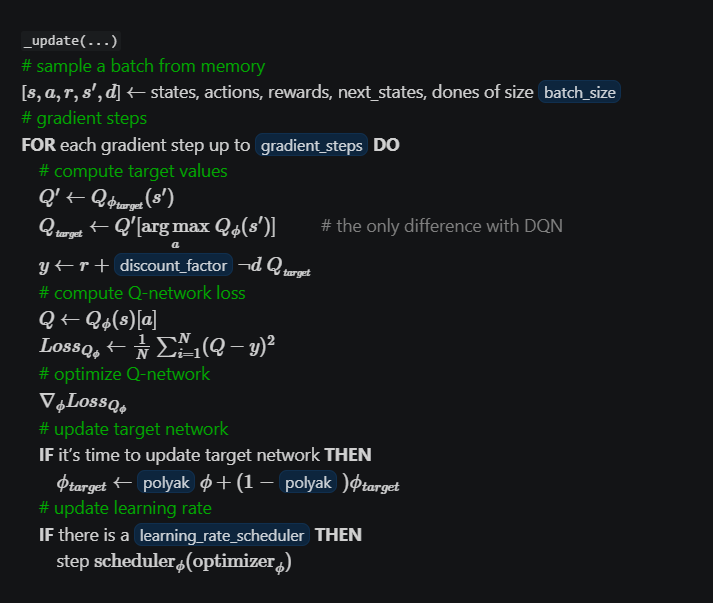

In [8]:
"""
Чем меньше число, тем более важны текущие награды. Чем больше число, тем важны награды в долгосрочной перспективе

"""
gamma = 0.7 #  0.95

def fit(batch, model, target_model, optimizer, mse_loss):
    state, action, reward, next_state = batch
    
    # Загружаем батч на выбранное ранее устройство
    # state = torch.tensor(np.array(state)).to(device).float()
    # next_state = torch.tensor(np.array(next_state)).to(device).float()
    # reward = torch.tensor(np.array(reward)).to(device).float()
    # action = np.array(action)
    
    state = torch.tensor(state, dtype = torch.float32).to(device)
    next_state = torch.tensor(next_state, dtype = torch.float32).to(device)
    reward = torch.tensor(reward, dtype = torch.float32).to(device)
    # action = np.array(action)
    
    # Массив индексов от 0 до размера массива действий
    row = np.arange(action.shape[0])
    # Массив индексов которые нужно занулить
    zero_index = np.array([1 if act == 0 else 0 for act in action])
    
    # Вычисление таргета
    with torch.no_grad():
        q_ =  target_model(next_state)
        
        index_argmax = torch.argmax(model(next_state), dim = 1)
        
        target_q = q_
        
        target_q[row, index_argmax] = reward + gamma * target_q[row, index_argmax]
    
    
    q = model(state)
    # target_q[row, zero_index] = 0
    # q[row, zero_index] = 0
    
    """
    # ________ Мой метод ________
    
    # Вычисляем q из предсказания модели
    q = model(state) #.gather(1, action.unsqueeze(1))
    
    with torch.no_grad():
        # Выбираем максимальное из значений Q-function для следующих состояний
        # Максимальное значение предсказания модели target_model
        q_ = target_model(next_state)
        
    # Вычисляем максимальное q из предсказания модели
    maxq = q_.amax(dim = 1)
    
    target_q = q.clone().detach()
    
    target_q[row, action] = reward + maxq * gamma
    target_q[row, zero_index] = 0
    q[row, zero_index] = 0
    
    
    # ________ Конец ________
    """
    
    # reward - награждения 
    # gamma - константа
    
    # print(target_q)
    # print(q)
    # Очищаем текущие градиенты внутри сети
    optimizer.zero_grad()
    
    loss =  mse_loss(q, target_q)
    # Применяем обратное распространение  ошибки
    loss.backward()
    # Делаем шаг оптимизации
    
#     for param in model.parameters():
#         param.grad.data.clamp_(-1, 1)
    
    optimizer.step()

## Буфер

TODO: сделать новый класс Memory на Torch
1. Испльзовать [BatchSampler](https://pytorch.org/docs/stable/data.html) и в [RandomSampler](https://pytorch.org/docs/stable/data.html#torch.utils.data.Sampler)

In [9]:
# class Memory:
#     def __init__(self, capacity):
#         self.capacity = capacity # Ёмкость памяти
#         self.memory = []
#         # self.memory_many_elements = [] # Массив для сделок
#         # self.position = 0
    
#     def push(self, element):
#         """
#         element (list): [state, action, reward, new_state, done]
#         """
#         self.memory.append(element)

#         if len(self.memory) == self.capacity: # Если длинна списка выше емкости, удаляем первый элемент
#             self.memory.pop(0)
        
#     def sample(self, batch_size):
#         """Возвращает случайную выборку указанного размера"""
#         return list(zip(*random.sample(self.memory, batch_size)))

In [10]:
# class Memory:
#     def __init__(self, capacity):
#         self.capacity = capacity # Ёмкость памяти
#         self.memory_good = []
#         self.memory_bad = []
#         # self.memory_many_elements = [] # Массив для сделок
#         # self.position = 0
    
#     def push(self, element):
#         """
#         element (list): [state, action, reward, new_state]
#         """
#         if element[2] <= 0:
#             self.memory_bad.append(element)
#         else:
#             self.memory_good.append(element)

#         if len(self.memory_bad) == self.capacity: # Если длинна списка выше емкости, удаляем первый элемент
#             self.memory_bad.pop(0)
#         if len(self.memory_good) == self.capacity:
#             self.memory_good.pop(0)
        

#     def sample(self, batch_size, split_coef:float = 0.65):
#         """Возвращает случайную выборку указанного размера"""

#         good_sample = int(batch_size*split_coef)
#         bad_sample = batch_size - good_sample

#         if len(self.memory_good) < good_sample or len(self.memory_bad) < bad_sample:
#             return list(zip(*random.sample(self.memory_good + self.memory_bad, batch_size))) 

#         else:
#             return list(zip(*random.sample(self.memory_good, good_sample)+random.sample(self.memory_bad, bad_sample)))

In [11]:
class Memory:
    def __init__(self, capacity, shape_state = 180):
        self.capacity = capacity # Ёмкость памяти
        self.memory_state = np.zeros((self.capacity, shape_state))
        self.memory_action = np.zeros((self.capacity,))
        self.memory_reward = np.zeros((self.capacity,))
        self.memory_new_state = np.zeros((self.capacity, shape_state))
        
        self.idx = 0
        
        self.full_memory = False
        
        # self.memory_many_elements = [] # Массив для сделок
        # self.position = 0
    
    def push(self, element):
        """
        element (list): [state, action, reward, new_state]
        """
        
        self.memory_state[self.idx] = element[0]
        self.memory_action[self.idx] = element[1]
        self.memory_reward[self.idx] = element[2]
        self.memory_new_state[self.idx] = element[3]
            
        if self.idx == (self.capacity-1):
            self.idx = 0
            self.full_memory = True
            
        else:
            self.idx += 1
        
        

    def sample(self, batch_size, split_coef:float = 0.65):
        """Возвращает случайную выборку указанного размера"""
        
        if self.full_memory == False:
            indexes = random.sample(list(range(self.idx)), batch_size)
        else:
            indexes = random.sample(list(range(self.memory_action.shape[0])), batch_size)
        
        
        return self.memory_state[indexes], self.memory_action[indexes], self.memory_reward[indexes], self.memory_new_state[indexes]
            
        

## Memory, который учитывает вероятности

In [12]:
# class Memory:
#     def __init__(self, capacity, shape_state = 180):
#         self.capacity = capacity # Ёмкость памяти
#         self.memory_state = np.zeros((self.capacity, shape_state))
#         self.memory_action = np.zeros((self.capacity,))
#         self.memory_reward = np.zeros((self.capacity,))
#         self.memory_new_state = np.zeros((self.capacity, shape_state))
#         self.probabilities = np.zeros((self.capacity,))
        
#         self.idx = 0
        
#         self.full_memory = False
        
#         # self.memory_many_elements = [] # Массив для сделок
#         # self.position = 0
    
#     def push(self, element):
#         """
#         element (list): [state, action, reward, new_state]
#         """
        
#         self.memory_state[self.idx] = element[0]
#         self.memory_action[self.idx] = element[1]
#         self.memory_reward[self.idx] = element[2]
#         self.memory_new_state[self.idx] = element[3]
        
#         self.probabilities[self.idx] = element[2] if element[2] >0 else 0
        
#         if self.idx == (self.capacity-1):
#             self.idx = 0
#             self.full_memory = True
            
#         else:
#             self.idx += 1
        
        

#     def sample(self, batch_size, split_coef:float = 0.65):
#         """Возвращает случайную выборку указанного размера"""
        
#         if self.full_memory == False:
#             # indexes = random.sample(list(range(self.idx)), batch_size)
#             probabilities = self.probabilities[:self.idx]
#             probabilities = probabilities / np.sum(probabilities)
            
            
#             indexes = np.random.choice(list(range(self.idx)), batch_size, p=probabilities)
            
#         else:
#             # indexes = random.sample(list(range(self.memory_action.shape[0])), batch_size)
#             probabilities = self.probabilities[:self.idx]
#             probabilities = probabilities / np.sum(probabilities)
            
#             indexes = np.random.choice(list(range(self.memory_action.shape[0])), batch_size, p=probabilities)
        
#         return self.memory_state[indexes], self.memory_action[indexes], self.memory_reward[indexes], self.memory_new_state[indexes]
            
        

In [13]:
r = {1: 1, 3: [1, 2, 3]}
len(r)

2

In [14]:
# device = torch.device("cuda:0")

def select_action(state, epsilon, model):
    if random.random() < epsilon:
        return random.randint(0, 1)
    with torch.no_grad():
        # print(model(torch.tensor(state).to(device)).float())
        return model(torch.tensor(state).to(device).float()).argmax().item()

### Объект history
```py
data_stock = {
            "step": self.t,
            "idx": self.t + self.n_candle - 1, 
            "date": np.datetime64(self.data.iloc[self.t + self.n_candle - 1].name),
            "position": action,

            "data_close": self.data.iloc[self.t + self.n_candle - 1]['close'],
            "data_high": self.data.iloc[self.t + self.n_candle - 1]['high'],
            "data_low": self.data.iloc[self.t + self.n_candle - 1]['low'],
            "data_open": self.data.iloc[self.t + self.n_candle - 1]['open'],
            "data_volume": self.data.iloc[self.t + self.n_candle - 1]['volume'],

            "quantity_stock": quantity_stock,
            "portfolio_valuation": portfolio_valuation,
        }
```

In [15]:
n_candle = 10
split_size = 0.1
start_balance = 10000
# trans_commission = 0.0005
trans_commission = 0.003

# date_val = data[0].index[-1] - relativedelta(months=2)
# date_test = data[0].index[-1] - relativedelta(months=1)

date_val = data[0].index[-1] - timedelta(days = 28*2)
# date_test = data[0].index[-1] - timedelta(days = 28)

print(f"Val: {date_val}\t\t test: {date_val}")


def reward_function(history):
    """ 
    reward = (последняя оценка портфеля - максимальная оценка за 50 предыдущих шагов) * 300 - 1
    
    """
    
    # return (history['portfolio_valuation'][-1] - history['portfolio_valuation'][0])/ history['portfolio_valuation'][0]
    reward = float((history['portfolio_valuation'][-1] - np.max(history['portfolio_valuation'][-50:-1])) * 300 - 1)
    
    # reward = reward / abs(reward)
    
    return reward


env = MultiDatasetTradingEnv(
    name_list=["yandex", "sber", "gazprom", "vtb"],
    data_list = [df[df.index < date_val] for df in data],
    n_candle = n_candle,
    reward_function = reward_function,
    trans_commission = trans_commission,
    start_balance = start_balance,
)

# env_val = TradingEnv(
#     name = "Yandex_val", 
#     data = data[0][(data[0].index >= date_val) & (data[0].index < date_test)], 
#     n_candle = n_candle, 
#     reward_function = reward_function, 
#     trans_commission = trans_commission, 
#     start_balance = start_balance, 
#     visualize=True
# )

# env_test = TradingEnv(
#     name = "Yandex_test", 
#     data = data[0][data[0].index >= date_test], 
#     n_candle = n_candle, 
#     reward_function = reward_function, 
#     trans_commission = trans_commission, 
#     start_balance = start_balance, 
#     visualize=True
# )

env_val = TradingEnv(
    name = "Yandex_val", 
    data = data[0][(data[0].index >= date_val)], 
    n_candle = n_candle, 
    reward_function = reward_function, 
    trans_commission = trans_commission, 
    start_balance = start_balance, 
    visualize=True
)

env_test = TradingEnv(
    name = "Yandex_test", 
    data = data[0][(data[0].index >= date_val)], 
    n_candle = n_candle, 
    reward_function = reward_function, 
    trans_commission = trans_commission, 
    start_balance = start_balance, 
    visualize=True
)



Val: 2024-02-10 14:00:00		 test: 2024-02-10 14:00:00


In [16]:
data[0].index.max()

Timestamp('2024-04-06 14:00:00')

In [17]:
data[0].index[-1], data[0].index[-1] - timedelta(days = 1)

(Timestamp('2024-04-06 14:00:00'), Timestamp('2024-04-05 14:00:00'))

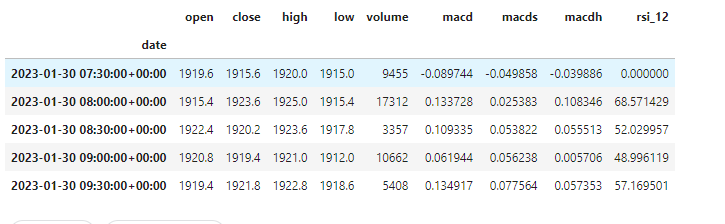

In [18]:
r = ((1, 2, 3), (4, 5, 6), (7, 8, 9), (10, 11, 12), (13, 14, 15))
for nw_st, r, d, t, i in zip(*((1, 2, 3), (4, 5, 6), (7, 8, 9), (10, 11, 12), (13, 14, 15))):
    print(nw_st, r, d, t, i)

1 4 7 10 13
2 5 8 11 14
3 6 9 12 15


In [19]:
list(i for i in range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [20]:
env.reset(3)[0].shape

(10, 18)

In [21]:
True and False

False

In [22]:
def standartizer(array):
    """
    Метод для стандартизации данных
    
    Столбцы 0: Объём торгов 
    Столбцы 1 - 5: Свечи
    Столбцы 5 - 14: Время дня и прочие данные по времени
    Столбцы 14 - 18: Индикаторы

    """
    valume = array[:, 0].copy()
    array_candle = array[:, 1:5].copy()
    time_date = array[:, 5:14].copy()
    indicators = array[:, 14:18].copy()
    
    # Стандартизируем объёмы
    array_candle = (array_candle - array_candle.min()) / (array_candle.max() - array_candle.min())
    valume = (valume - valume.min()) / (valume.max() - valume.min())

    array = np.c_[indicators, array_candle]
    array = np.c_[array, valume]
    array = np.c_[array, time_date]

    return array.reshape(-1)


def evaluate(env_for_eval, target_model):
    done_val, truncated_val = False, False
    state_val, info_val = env_for_eval.reset()

    all_reward = []
    count_i = 0
    while (not done_val) and (not truncated_val):
        count_i+=1
        state_val = standartizer(state_val)
        action_val = int(select_action(state_val, 0, target_model))
        state_val, reward_test, done_val, truncated_val, info_val = env_for_eval.step(action_val)
        if count_i>10000:
            print('Тут что то не то')
            break
    return round(info_val['portfolio_valuation'], 3), env_for_eval

def main():
    #Количество обновлений model между обновлениями target model
    target_update = 512 # 2**7 # 32 
    
    #Размер одного батча, который на вход принимает модель
    batch_size = 2**11 # 512
    #Количество шагов среды
    max_steps = 250001  
    #Границы коэффициента exploration
    epsilon = 1
    log_step = 10000
    epsilon_update = 600 # 300
    
    # Переменная для опредления максимальной оценки портфеля
    max_portfolio = 10000
    
    # сохранять модель каждые n шагов
    save_model_every = 10000
    
    # Каждые 4 шага обучаем модель
    model_update = 2**0
    
    # Тестирование агента 
    agent_test = target_update * 1

    
    done, truncated = [False]*4, [False]*4
    state, info = env.reset()

    state = list(standartizer(x) for x in state)
    # state = standartizer(state)
    
    memory = Memory(max_steps * 3, shape_state = state[0].shape[0]) # 6144
    
    model, target_model, optimizer = create_new_model(state[0].shape)
    mse_loss = nn.MSELoss()
    
    balance = []
    
    for step in tqdm(range(max_steps)):
        #print(np.array([state]).shape)

        action = []
        for st in state:
            action.append(select_action(st, epsilon, model))

        new_state, reward, done, truncated, info = env.step(action)

        done = list(done)
        truncated = list(truncated)

        # Стандартизируем состояния
        new_state = list(standartizer(x) for x in new_state)

        for i in range(len(done)):
            memory.push([state[i], action[i], reward[i], new_state[i]])

            # Проверка на конец состояния
            if done[i] or truncated[i]:
                st, inf = env.reset(i)
                
                state[i] = standartizer(st)
                done[i], truncated[i] = False, False

                print(f"\n\n name: {env.name_list[i]} \t portfolio_valuation: {info[i]['portfolio_valuation']}\n\n")
            
            else:
                state[i] = new_state[i]
        
        # Выводим значение epsilon
        if step % (epsilon_update*5) == 0 and epsilon > 0.05:
            print(f"\n\n epsilon: {epsilon}\n\n")

        # Обновляем значение epsilon
        if step % epsilon_update == 0 and epsilon > 0.05:
            epsilon -= 0.005
        
        # Сохраняем промежуточные модели
        if step%save_model_every == 0 and step>1:
            torch.save(target_model, f"/kaggle/working/model_{step}.pth")
        
        #Градиентный спуск
        if step > batch_size and step % model_update==0: # and len(memory.memory) >= batch_size
            fit(memory.sample(batch_size), model, target_model, optimizer, mse_loss)
            # break
            
        if step % target_update == 0 and step != 0:
            target_model = copy.deepcopy(model)
            
            if step % agent_test == 0:
                
                portfolio_val, env_after_eval = evaluate(env_val, target_model)
                balance.append(portfolio_val)
                
                if max_portfolio < portfolio_val:
                    max_portfolio = portfolio_val
                    # env_after_eval.unwrapped.save_for_render(dir = "/kaggle/working/")
                    
                    portfolio_test, env_after_eval = evaluate(env_test, target_model)
                    torch.save(target_model, "/kaggle/working/best_model.pth")
                    
                    # env_after_eval.unwrapped.save_for_render(dir = "/kaggle/working/")
                    
                    print("*"*100)
                    print('\n\n')
                    print(f"Обновлён максимум на валидации: {max_portfolio} \t время: {datetime.datetime.now()}")
                    print(f'Баланс на тесте: {portfolio_test}')
                    print('\n\n')
                    print("*"*100)
                    
                    
            # Сохраняем эксперемент 
            # env_test.unwrapped.save_for_render(dir = "/kaggle/working/")
            
            
        if step % log_step == 0 and step != 0:
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=list(range(0, len(balance))), y=balance))
            fig.update_layout(
                  title="График баланса",
                  xaxis_title="Номер наблюдения",
                  yaxis_title="Баланс"
                  #yaxis_title="Баланс после сделки"
            )
            fig.show()
            


In [ ]:
main()

  0%|          | 12/250001 [00:00<1:08:51, 60.52it/s]



 epsilon: 1




  0%|          | 485/250001 [00:01<15:08, 274.77it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11104.003 (11.04 %)	|	Кол-во сделок: 12	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  0%|          | 541/250001 [00:04<1:18:23, 53.03it/s]

Name: Yandex_test	|	Market return: 21.43 %	|	Portfolio valuation: 11104.003 (11.04 %)	|	Кол-во сделок: 12	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00
****************************************************************************************************



Обновлён максимум на валидации: 11104.003 	 время: 2024-05-07 07:31:23.130101
Баланс на тесте: 11104.003



****************************************************************************************************


  0%|          | 1073/250001 [00:07<47:34, 87.22it/s]  

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11104.003 (11.04 %)	|	Кол-во сделок: 12	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  1%|          | 1570/250001 [00:09<47:45, 86.69it/s]  

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11104.003 (11.04 %)	|	Кол-во сделок: 12	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  1%|          | 2039/250001 [00:11<15:31, 266.25it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11104.003 (11.04 %)	|	Кол-во сделок: 12	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  1%|          | 2559/250001 [00:19<52:37, 78.36it/s]  

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 12038.595 (20.39 %)	|	Кол-во сделок: 1	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  1%|          | 2575/250001 [00:22<4:28:03, 15.38it/s]

Name: Yandex_test	|	Market return: 21.43 %	|	Portfolio valuation: 12038.595 (20.39 %)	|	Кол-во сделок: 1	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00
****************************************************************************************************



Обновлён максимум на валидации: 12038.595 	 время: 2024-05-07 07:31:41.039721
Баланс на тесте: 12038.595



****************************************************************************************************


  1%|          | 3013/250001 [00:27<50:34, 81.39it/s]  



 epsilon: 0.975




  1%|          | 3085/250001 [00:29<2:27:22, 27.93it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 12038.595 (20.39 %)	|	Кол-во сделок: 1	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  1%|▏         | 3594/250001 [00:36<2:28:16, 27.70it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11228.208 (12.28 %)	|	Кол-во сделок: 6	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  2%|▏         | 4105/250001 [00:44<2:26:22, 28.00it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10000 (0.0 %)	|	Кол-во сделок: 0	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  2%|▏         | 4620/250001 [00:51<2:35:59, 26.22it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10812.352 (8.12 %)	|	Кол-во сделок: 7	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  2%|▏         | 5132/250001 [00:59<2:33:31, 26.58it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 9818.853 (-1.81 %)	|	Кол-во сделок: 23	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  2%|▏         | 5644/250001 [01:07<2:34:29, 26.36it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10679.501 (6.8 %)	|	Кол-во сделок: 17	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  2%|▏         | 6009/250001 [01:12<51:41, 78.67it/s]  



 epsilon: 0.95




  2%|▏         | 6154/250001 [01:14<2:34:50, 26.25it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 9622.533 (-3.77 %)	|	Кол-во сделок: 23	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  3%|▎         | 6284/250001 [01:16<53:41, 75.64it/s]  



 name: vtb 	 portfolio_valuation: 204.82740000017142




  3%|▎         | 6396/250001 [01:18<55:59, 72.52it/s]



 name: sber 	 portfolio_valuation: 1576.1869000001675




 name: yandex 	 portfolio_valuation: 1838.866000000141




 name: gazprom 	 portfolio_valuation: 1516.2874000001875




  3%|▎         | 6671/250001 [01:22<2:36:58, 25.84it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 9361.22 (-6.39 %)	|	Кол-во сделок: 47	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  3%|▎         | 7178/250001 [01:30<2:38:16, 25.57it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10459.544 (4.6 %)	|	Кол-во сделок: 20	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  3%|▎         | 7692/250001 [01:37<2:30:45, 26.79it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 9811.811 (-1.88 %)	|	Кол-во сделок: 29	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  3%|▎         | 8200/250001 [01:45<3:08:18, 21.40it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 9282.824 (-7.17 %)	|	Кол-во сделок: 34	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  3%|▎         | 8712/250001 [01:53<3:17:30, 20.36it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 8959.385 (-10.41 %)	|	Кол-во сделок: 34	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  4%|▎         | 9008/250001 [01:57<55:08, 72.84it/s]  



 epsilon: 0.9249999999999999




  4%|▎         | 9229/250001 [02:01<2:37:47, 25.43it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 8778.14 (-12.22 %)	|	Кол-во сделок: 36	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  4%|▍         | 9741/250001 [02:09<2:39:53, 25.04it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 9216.225 (-7.84 %)	|	Кол-во сделок: 29	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  4%|▍         | 9996/250001 [02:13<55:20, 72.27it/s]  

  4%|▍         | 10249/250001 [02:19<3:54:53, 17.01it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 9334.711 (-6.65 %)	|	Кол-во сделок: 26	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  4%|▍         | 10761/250001 [02:29<3:44:29, 17.76it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10815.276 (8.15 %)	|	Кол-во сделок: 12	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  5%|▍         | 11271/250001 [02:39<3:32:06, 18.76it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11119.027 (11.19 %)	|	Кол-во сделок: 12	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  5%|▍         | 11788/250001 [02:50<3:32:48, 18.66it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10895.017 (8.95 %)	|	Кол-во сделок: 11	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  5%|▍         | 12008/250001 [02:54<1:07:07, 59.10it/s]



 epsilon: 0.8999999999999999




  5%|▍         | 12295/250001 [03:00<3:46:40, 17.48it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10749.88 (7.5 %)	|	Кол-во сделок: 14	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  5%|▌         | 12553/250001 [03:05<1:11:47, 55.13it/s]



 name: vtb 	 portfolio_valuation: 215.9080500001746




  5%|▌         | 12781/250001 [03:09<1:13:20, 53.91it/s]



 name: sber 	 portfolio_valuation: 1571.7044000001758




 name: yandex 	 portfolio_valuation: 1838.6086000001458




  5%|▌         | 12799/250001 [03:09<1:09:53, 56.56it/s]



 name: gazprom 	 portfolio_valuation: 1516.1037000001547




  5%|▌         | 12811/250001 [03:10<3:26:42, 19.12it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10588.075 (5.88 %)	|	Кол-во сделок: 13	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  5%|▌         | 13320/250001 [03:20<3:19:27, 19.78it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10708.338 (7.08 %)	|	Кол-во сделок: 15	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  6%|▌         | 13835/250001 [03:29<3:34:51, 18.32it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10743.868 (7.44 %)	|	Кол-во сделок: 17	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  6%|▌         | 14343/250001 [03:39<3:25:57, 19.07it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10821.744 (8.22 %)	|	Кол-во сделок: 16	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  6%|▌         | 14859/250001 [03:49<3:27:24, 18.90it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10392.867 (3.93 %)	|	Кол-во сделок: 15	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  6%|▌         | 15009/250001 [03:51<1:10:04, 55.89it/s]



 epsilon: 0.8749999999999999




  6%|▌         | 15369/250001 [03:59<3:41:14, 17.68it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10548.716 (5.49 %)	|	Кол-во сделок: 16	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  6%|▋         | 15883/250001 [04:09<3:24:47, 19.05it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10531.411 (5.31 %)	|	Кол-во сделок: 15	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  7%|▋         | 16392/250001 [04:19<3:20:17, 19.44it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10342.3 (3.42 %)	|	Кол-во сделок: 17	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  7%|▋         | 16908/250001 [04:29<3:37:23, 17.87it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10585.537 (5.86 %)	|	Кол-во сделок: 11	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  7%|▋         | 17419/250001 [04:39<3:29:55, 18.47it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10544.583 (5.45 %)	|	Кол-во сделок: 11	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  7%|▋         | 17928/250001 [04:49<3:28:55, 18.51it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10411.663 (4.12 %)	|	Кол-во сделок: 13	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  7%|▋         | 18011/250001 [04:51<1:11:46, 53.87it/s]



 epsilon: 0.8499999999999999




  7%|▋         | 18443/250001 [05:00<3:23:59, 18.92it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10541.37 (5.41 %)	|	Кол-во сделок: 12	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  8%|▊         | 18827/250001 [05:07<1:17:21, 49.81it/s]



 name: vtb 	 portfolio_valuation: 215.6152500001683




  8%|▊         | 18953/250001 [05:11<3:26:09, 18.68it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10618.694 (6.19 %)	|	Кол-во сделок: 12	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  8%|▊         | 19171/250001 [05:15<1:14:15, 51.81it/s]



 name: sber 	 portfolio_valuation: 1575.2542000001624




 name: yandex 	 portfolio_valuation: 1832.7420000001518




  8%|▊         | 19195/250001 [05:15<1:11:32, 53.77it/s]



 name: gazprom 	 portfolio_valuation: 1522.8962000001493




  8%|▊         | 19465/250001 [05:21<3:26:16, 18.63it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10731.99 (7.32 %)	|	Кол-во сделок: 12	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  8%|▊         | 19975/250001 [05:31<3:24:41, 18.73it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10731.301 (7.31 %)	|	Кол-во сделок: 12	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  8%|▊         | 19999/250001 [05:32<1:41:20, 37.83it/s]

  8%|▊         | 20491/250001 [05:42<3:16:52, 19.43it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10714.192 (7.14 %)	|	Кол-во сделок: 11	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  8%|▊         | 21004/250001 [05:52<3:19:22, 19.14it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10701.81 (7.02 %)	|	Кол-во сделок: 11	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 epsilon: 0.8249999999999998




  9%|▊         | 21514/250001 [06:02<3:20:37, 18.98it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10527.856 (5.28 %)	|	Кол-во сделок: 12	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  9%|▉         | 22024/250001 [06:13<3:16:50, 19.30it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10423.218 (4.23 %)	|	Кол-во сделок: 15	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  9%|▉         | 22538/250001 [06:23<3:22:15, 18.74it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10267.674 (2.68 %)	|	Кол-во сделок: 18	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  9%|▉         | 23047/250001 [06:34<3:36:28, 17.47it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10204.496 (2.04 %)	|	Кол-во сделок: 21	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


  9%|▉         | 23562/250001 [06:44<3:27:11, 18.21it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10301.768 (3.02 %)	|	Кол-во сделок: 19	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 10%|▉         | 24008/250001 [06:53<1:10:20, 53.54it/s]



 epsilon: 0.7999999999999998




 10%|▉         | 24074/250001 [06:55<3:20:16, 18.80it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10361.73 (3.62 %)	|	Кол-во сделок: 18	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 10%|▉         | 24583/250001 [07:06<3:58:36, 15.75it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10190.532 (1.91 %)	|	Кол-во сделок: 20	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 10%|█         | 25096/250001 [07:18<3:54:50, 15.96it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10226.648 (2.27 %)	|	Кол-во сделок: 16	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 name: vtb 	 portfolio_valuation: 213.77695000018693




 10%|█         | 25555/250001 [07:27<1:14:55, 49.93it/s]



 name: sber 	 portfolio_valuation: 1669.517100000181




 name: yandex 	 portfolio_valuation: 1869.6450000001598




 10%|█         | 25590/250001 [07:28<1:11:59, 51.96it/s]



 name: gazprom 	 portfolio_valuation: 1530.9794000001418




 10%|█         | 25608/250001 [07:29<3:26:28, 18.11it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10379.511 (3.8 %)	|	Кол-во сделок: 15	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 10%|█         | 26124/250001 [07:40<3:19:52, 18.67it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10340.406 (3.4 %)	|	Кол-во сделок: 18	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 11%|█         | 26633/250001 [07:50<3:33:58, 17.40it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10466.295 (4.66 %)	|	Кол-во сделок: 15	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 11%|█         | 27011/250001 [07:57<1:06:55, 55.53it/s]



 epsilon: 0.7749999999999998




 11%|█         | 27143/250001 [08:00<3:14:03, 19.14it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10358.063 (3.58 %)	|	Кол-во сделок: 18	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 11%|█         | 27659/250001 [08:11<3:20:17, 18.50it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10537.825 (5.38 %)	|	Кол-во сделок: 14	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 11%|█▏        | 28168/250001 [08:22<3:38:36, 16.91it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10663.081 (6.63 %)	|	Кол-во сделок: 13	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 11%|█▏        | 28683/250001 [08:33<3:15:03, 18.91it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10440.082 (4.4 %)	|	Кол-во сделок: 15	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 12%|█▏        | 29190/250001 [08:43<4:14:40, 14.45it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10503.683 (5.04 %)	|	Кол-во сделок: 15	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 12%|█▏        | 29706/250001 [08:55<3:29:28, 17.53it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10548.293 (5.48 %)	|	Кол-во сделок: 13	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 12%|█▏        | 29998/250001 [09:00<1:16:40, 47.82it/s]



 epsilon: 0.7499999999999998




 12%|█▏        | 30215/250001 [09:06<3:37:41, 16.83it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10625.862 (6.26 %)	|	Кол-во сделок: 12	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 12%|█▏        | 30729/250001 [09:17<3:28:40, 17.51it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10874.444 (8.74 %)	|	Кол-во сделок: 9	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 12%|█▏        | 31240/250001 [09:29<3:41:32, 16.46it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11531.398 (15.31 %)	|	Кол-во сделок: 7	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 13%|█▎        | 31373/250001 [09:32<1:15:11, 48.46it/s]



 name: vtb 	 portfolio_valuation: 215.5403000001479




 13%|█▎        | 31750/250001 [09:40<3:40:20, 16.51it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10930.651 (9.31 %)	|	Кол-во сделок: 8	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 13%|█▎        | 31939/250001 [09:44<1:12:58, 49.80it/s]



 name: sber 	 portfolio_valuation: 1561.3411000001695




 name: yandex 	 portfolio_valuation: 1856.7558000001322




 13%|█▎        | 31981/250001 [09:45<1:08:10, 53.30it/s]



 name: gazprom 	 portfolio_valuation: 1516.0199000001562




 13%|█▎        | 32263/250001 [09:51<3:08:33, 19.25it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11603.213 (16.03 %)	|	Кол-во сделок: 7	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 13%|█▎        | 32779/250001 [10:02<3:14:27, 18.62it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11497.55 (14.98 %)	|	Кол-во сделок: 7	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 13%|█▎        | 33005/250001 [10:06<1:09:49, 51.79it/s]



 epsilon: 0.7249999999999998




 13%|█▎        | 33288/250001 [10:13<3:15:55, 18.44it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11010.157 (10.1 %)	|	Кол-во сделок: 7	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 14%|█▎        | 33799/250001 [10:25<3:45:56, 15.95it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10913.763 (9.14 %)	|	Кол-во сделок: 9	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 14%|█▎        | 34312/250001 [10:36<3:14:44, 18.46it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10790.223 (7.9 %)	|	Кол-во сделок: 11	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 14%|█▍        | 34825/250001 [10:47<3:20:38, 17.87it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10959.099 (9.59 %)	|	Кол-во сделок: 8	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 14%|█▍        | 35334/250001 [10:59<3:53:34, 15.32it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11580.387 (15.8 %)	|	Кол-во сделок: 7	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 14%|█▍        | 35849/250001 [11:11<3:54:55, 15.19it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11592.066 (15.92 %)	|	Кол-во сделок: 6	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 14%|█▍        | 36009/250001 [11:14<1:17:10, 46.21it/s]



 epsilon: 0.6999999999999997




 15%|█▍        | 36361/250001 [11:22<3:41:55, 16.04it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11591.464 (15.91 %)	|	Кол-во сделок: 6	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 15%|█▍        | 36871/250001 [11:34<3:40:20, 16.12it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11615.994 (16.16 %)	|	Кол-во сделок: 6	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 15%|█▍        | 37385/250001 [11:46<3:42:16, 15.94it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11720.592 (17.21 %)	|	Кол-во сделок: 5	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 15%|█▌        | 37645/250001 [11:52<1:16:55, 46.01it/s]



 name: vtb 	 portfolio_valuation: 216.86345000016232




 15%|█▌        | 37894/250001 [11:58<3:58:36, 14.82it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11553.486 (15.53 %)	|	Кол-во сделок: 7	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 15%|█▌        | 38329/250001 [12:08<1:15:40, 46.62it/s]



 name: sber 	 portfolio_valuation: 1610.8890000001768




 15%|█▌        | 38340/250001 [12:08<1:13:31, 47.98it/s]



 name: yandex 	 portfolio_valuation: 1818.5450000001354




 15%|█▌        | 38378/250001 [12:09<1:12:06, 48.91it/s]



 name: gazprom 	 portfolio_valuation: 1534.9809000001676




 15%|█▌        | 38408/250001 [12:11<3:13:02, 18.27it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11647.71 (16.48 %)	|	Кол-во сделок: 6	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 16%|█▌        | 38918/250001 [12:22<3:15:45, 17.97it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11074.88 (10.75 %)	|	Кол-во сделок: 7	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 16%|█▌        | 39010/250001 [12:23<1:11:36, 49.11it/s]



 epsilon: 0.6749999999999997




 16%|█▌        | 39433/250001 [12:33<3:31:17, 16.61it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11051.595 (10.52 %)	|	Кол-во сделок: 7	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 16%|█▌        | 39945/250001 [12:44<3:18:47, 17.61it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11163.725 (11.64 %)	|	Кол-во сделок: 5	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 16%|█▌        | 39996/250001 [12:45<1:14:57, 46.69it/s]

 16%|█▌        | 40457/250001 [12:56<3:37:43, 16.04it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11713.227 (17.13 %)	|	Кол-во сделок: 5	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 16%|█▋        | 40970/250001 [13:08<3:38:11, 15.97it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 10960.742 (9.61 %)	|	Кол-во сделок: 8	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 17%|█▋        | 41481/250001 [13:20<3:50:23, 15.08it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11173.115 (11.73 %)	|	Кол-во сделок: 5	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 17%|█▋        | 41991/250001 [13:32<3:39:02, 15.83it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11716.895 (17.17 %)	|	Кол-во сделок: 6	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 17%|█▋        | 42006/250001 [13:32<2:03:25, 28.09it/s]



 epsilon: 0.6499999999999997




 17%|█▋        | 42501/250001 [13:44<4:42:29, 12.24it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11166.734 (11.67 %)	|	Кол-во сделок: 5	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 17%|█▋        | 43016/250001 [13:57<3:43:56, 15.40it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11130.864 (11.31 %)	|	Кол-во сделок: 6	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 17%|█▋        | 43528/250001 [14:10<3:48:31, 15.06it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11053.013 (10.53 %)	|	Кол-во сделок: 8	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 18%|█▊        | 43918/250001 [14:19<1:21:22, 42.21it/s]



 name: vtb 	 portfolio_valuation: 213.18550000019073




 18%|█▊        | 44038/250001 [14:23<3:39:52, 15.61it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11133.638 (11.34 %)	|	Кол-во сделок: 6	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 18%|█▊        | 44553/250001 [14:36<3:44:49, 15.23it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11701.425 (17.01 %)	|	Кол-во сделок: 5	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 18%|█▊        | 44715/250001 [14:40<1:17:40, 44.04it/s]



 name: sber 	 portfolio_valuation: 1719.2948000001716




 18%|█▊        | 44730/250001 [14:40<1:15:49, 45.12it/s]



 name: yandex 	 portfolio_valuation: 1865.941400000146




 18%|█▊        | 44770/250001 [14:41<1:12:26, 47.22it/s]



 name: gazprom 	 portfolio_valuation: 1519.9758000001643




 18%|█▊        | 45009/250001 [14:46<1:06:36, 51.29it/s]



 epsilon: 0.6249999999999997




 18%|█▊        | 45065/250001 [14:48<3:33:27, 16.00it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11130.266 (11.3 %)	|	Кол-во сделок: 6	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 18%|█▊        | 45575/250001 [14:59<3:30:55, 16.15it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11038.113 (10.38 %)	|	Кол-во сделок: 9	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 18%|█▊        | 46088/250001 [15:11<3:38:22, 15.56it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11039.055 (10.39 %)	|	Кол-во сделок: 8	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 19%|█▊        | 46599/250001 [15:23<3:29:55, 16.15it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11024.155 (10.24 %)	|	Кол-во сделок: 9	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 19%|█▉        | 47114/250001 [15:35<3:31:51, 15.96it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11070.769 (10.71 %)	|	Кол-во сделок: 8	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 19%|█▉        | 47624/250001 [15:48<3:58:45, 14.13it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11024.155 (10.24 %)	|	Кол-во сделок: 9	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 19%|█▉        | 48007/250001 [15:57<1:26:50, 38.77it/s]



 epsilon: 0.5999999999999996




 19%|█▉        | 48135/250001 [16:01<3:53:12, 14.43it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11756.127 (17.56 %)	|	Кол-во сделок: 4	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 19%|█▉        | 48645/250001 [16:15<3:57:47, 14.11it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11808.503 (18.09 %)	|	Кол-во сделок: 4	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 20%|█▉        | 49157/250001 [16:30<4:14:04, 13.17it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11173.481 (11.73 %)	|	Кол-во сделок: 6	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 20%|█▉        | 49670/250001 [16:44<4:20:30, 12.82it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11844.788 (18.45 %)	|	Кол-во сделок: 6	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 20%|█▉        | 49999/250001 [16:53<1:30:33, 36.81it/s]

 20%|██        | 50181/250001 [16:59<4:00:10, 13.87it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11851.111 (18.51 %)	|	Кол-во сделок: 3	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 name: vtb 	 portfolio_valuation: 217.24950000017984




 20%|██        | 50696/250001 [17:13<4:14:11, 13.07it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11156.08 (11.56 %)	|	Кол-во сделок: 6	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 20%|██        | 51006/250001 [17:21<1:27:06, 38.07it/s]



 epsilon: 0.5749999999999996




 20%|██        | 51099/250001 [17:24<1:22:16, 40.29it/s]



 name: sber 	 portfolio_valuation: 1678.7891000001905




 20%|██        | 51119/250001 [17:24<1:20:28, 41.19it/s]



 name: yandex 	 portfolio_valuation: 1854.505400000176




 20%|██        | 51164/250001 [17:25<1:22:30, 40.17it/s]



 name: gazprom 	 portfolio_valuation: 1526.4282000001651




 20%|██        | 51208/250001 [17:27<3:54:12, 14.15it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11241.785 (12.42 %)	|	Кол-во сделок: 5	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 21%|██        | 51718/250001 [17:40<3:42:33, 14.85it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11220.121 (12.2 %)	|	Кол-во сделок: 5	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 21%|██        | 52230/250001 [17:53<3:33:40, 15.43it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11055.864 (10.56 %)	|	Кол-во сделок: 8	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 21%|██        | 52743/250001 [18:07<3:47:51, 14.43it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11015.472 (10.15 %)	|	Кол-во сделок: 9	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 21%|██▏       | 53256/250001 [18:21<4:24:33, 12.39it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11158.907 (11.59 %)	|	Кол-во сделок: 7	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 22%|██▏       | 53765/250001 [18:37<4:25:44, 12.31it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11886.183 (18.86 %)	|	Кол-во сделок: 6	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 22%|██▏       | 54005/250001 [18:43<1:34:42, 34.49it/s]



 epsilon: 0.5499999999999996




 22%|██▏       | 54277/250001 [18:52<4:26:57, 12.22it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11806.844 (18.07 %)	|	Кол-во сделок: 5	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 22%|██▏       | 54789/250001 [19:08<4:27:32, 12.16it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11892.201 (18.92 %)	|	Кол-во сделок: 6	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 22%|██▏       | 55301/250001 [19:23<4:28:10, 12.10it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11837.916 (18.38 %)	|	Кол-во сделок: 7	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 22%|██▏       | 55813/250001 [19:39<4:24:08, 12.25it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11892.201 (18.92 %)	|	Кол-во сделок: 6	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 23%|██▎       | 56325/250001 [19:55<4:31:20, 11.90it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11188.415 (11.88 %)	|	Кол-во сделок: 7	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 23%|██▎       | 56461/250001 [19:58<1:34:35, 34.10it/s]



 name: vtb 	 portfolio_valuation: 220.86855000018633




 23%|██▎       | 56837/250001 [20:10<4:26:37, 12.07it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11188.415 (11.88 %)	|	Кол-во сделок: 7	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 23%|██▎       | 57005/250001 [20:15<1:31:17, 35.24it/s]



 epsilon: 0.5249999999999996




 23%|██▎       | 57349/250001 [20:26<4:32:20, 11.79it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11188.415 (11.88 %)	|	Кол-во сделок: 7	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 23%|██▎       | 57489/250001 [20:30<1:34:32, 33.94it/s]



 name: sber 	 portfolio_valuation: 1698.6463000001668




 23%|██▎       | 57505/250001 [20:31<1:33:13, 34.41it/s]



 name: yandex 	 portfolio_valuation: 1871.90720000017




 23%|██▎       | 57561/250001 [20:32<1:26:21, 37.14it/s]



 name: gazprom 	 portfolio_valuation: 1582.3181000001675




 23%|██▎       | 57861/250001 [20:41<4:13:57, 12.61it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11462.823 (14.63 %)	|	Кол-во сделок: 8	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 23%|██▎       | 58376/250001 [20:56<4:19:28, 12.31it/s]

Name: Yandex_val	|	Market return: 21.43 %	|	Portfolio valuation: 11150.705 (11.51 %)	|	Кол-во сделок: 8	|	Период: 2024-02-10 14:00:00 - 2024-04-06 14:00:00


 24%|██▎       | 58833/250001 [21:08<1:23:20, 38.23it/s]

In [ ]:
print(1)